Our aim is  to differentiate between true sources of covid news and fake covid news. We will try to do this by looking into several COVID-19 related titles to try to predict if they are true or false. In particular we are aiming at getting a good detector of reliable news (true).

We will be given a multilingual dataset with COVID-19 related news, including some text elements, such as the original title (`source_title`), original body (`content_text`), and an English equivalent title (`title`). The dataset also includes a set of extra information that describes the language and countries of the story.

Each row is labeled with a category that describes the reliability of the news piece. We want to predict two classes - true or false. However,  the dataset has a range of categories, not only these two. 


In [1]:
import re
import nltk

from imblearn.ensemble import BalancedRandomForestClassifier,EasyEnsembleClassifier

from collections import Counter, OrderedDict
from sklearn.base import TransformerMixin,BaseEstimator
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.util import ngrams
import numpy as np
import hashlib
import math
import pandas as pd 
import matplotlib.pyplot as plt
import random
import string
from nltk.tokenize import WordPunctTokenizer

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
import spacy
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import preprocessing

from bs4 import BeautifulSoup
from spacy.lang.en import English

from pylab import barh,plot,yticks,show,grid,xlabel,figure,cla,close
from sklearn.linear_model import LinearRegression

# Regex

. - matches any character, except newline.

\d, \s \S - match digit, match whitespace, not whitespace.

\b, \B - word, not word boundary.

[xyz] - matches x, y or z.

[^xyz] - matches anything that is not x, y or z.

[x-z] - matches a character between x and z.

^xyz$ - ^ is the start of the string, $ is the end of the string.

\. - use escaping to match special characters.

\t, \n - matches tab and newline.

x* - matches 0 or more symbols x.

x+ - matches 1 or more symbols x.

x? - matches 0 or 1 symbol x.

.?, *?, +?, etc - represent non-greedy search.

x{5} - matches exactly 5 symbols x.

x{5,} - matches 5 or more symbols x.

x{5, 8} - matches between 5 and 8 symbols x.

xy|yz - matches xy or yz.

In [2]:
#nltk.download('stopwords')
#stemmer = SnowballStemmer("english", ignore_stopwords=True)
#stems = [list(map(stemmer.stem, words))]

# Read the data

In [3]:
#Load the dataset
##there are two columns in the data set sentiment which is positive and negative and text columns this is movie review
#df = pd.read_csv('./datasets/twitter.csv')
df_train_nb = pd.read_csv('./data/covid19_data.csv')#, encoding='latin1')
#df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1,inplace=True)
df_train_nb = df_train_nb[['class','title']]
df_train_nb.rename(columns={"class":"target", "title":"text"},inplace=True)
df_test= pd.read_csv('data/covid19_unlabelled_test.csv')

df_test = df_test[['title']]
df_test.rename(columns={"title":"text"},inplace=True)
df_test.head()
#NOTE: If the data set is so many choose part of that in order to accelerate the process of analysing
    ##docs = df.text[:200]
# Get the text
#docs = df['text']



###we can read from file and represent it as list as follows
#def file_to_list(file_name):
    #with open(file_name, 'r', encoding='utf-8') as f:
        #return [line.strip() for line in f.readlines()]
    
#X_train_pre = file_to_list('data/tweets_train_preprocessed.txt')
#X_dev_pre = file_to_list('data/tweets_dev_preprocessed.txt')
#X_test_pre = file_to_list('data/tweets_test_preprocessed.txt')

##############################################################Read a JSON file################################

#docs = []
#with open('./datasets/sample_data.json') as fp:
    #for line in fp:
        #entry = json.loads(line)
        #docs.append(entry['body'])
        
#print('I read {} documents'.format(len(docs)))

,text
0,American researcher Charles Lieber was arrest...
1,Did Trump Blame Obama for ‘Bad’ COVID-19 Tests...
2,Hundreds of sampoerna cigarette factory worke...
3,Dr. Megha Vyas from Pune died of COVID-19.
4,Jacob Rothschild owns a patent to coronavirus.


In [4]:
df_train_nb['target'].unique()

array(['FALSE', 'False', 'Correct Attribution', 'True', 'Explanatory',
       'false', 'Misleading', 'MISLEADING', 'Mostly True', 'No Evidence',
       'partly false', 'Mostly false', 'Partly false', 'PARTLY FALSE',
       'No evidence', 'Mostly False', 'misleading', 'Labeled Satire',
       'News', 'Partly False', 'Misleading/False', 'Mixture',
       'no evidence', 'MOSTLY FALSE', 'Misattributed', 'Unproven',
       'Miscaptioned', 'Fake', 'Half True', 'PARTLY TRUE', 'Not true',
       'Scam', "(Org. doesn't apply rating)", 'Partially false',
       'MOSTLY TRUE', 'Partly true', 'mislEADING', 'NO EVIDENCE',
       'half true', 'false and misleading', 'mostly false', nan,
       'HALF TRUE', 'Two Pinocchios', 'Suspicions', 'Partly FALSE',
       'PANTS ON FIRE', 'Correct', 'Misinformation / Conspiracy theory',
       'IN DISPUTE', 'HALF TRUTH', 'MiSLEADING', 'Partially correct',
       'Unlikely', 'Fake news', 'True but', 'Mostly true', 'Collections',
       'Mixed', 'Unverified', 'Pa

In [5]:
df_train = pd.read_csv('./data/df_10percTrue_with_noevidence.csv')
df_train.drop(["Unnamed: 0"], axis=1,inplace=True)
df_train.rename(columns={"label":"target", "title":"text"},inplace=True)
df_train

,text,target
0,A viral image suggests that cocaine kills cor...,f
1,Having sex every morning kills coronavirus.,f
2,Picture shows the Mecca totally empty.,f
3,Queen Elizabeth is shown in a quote card to b...,f
4,Official news: in Naples people have used Toc...,f
...,...,...
1755,Bill Gates patented the coronavirus.,t
1756,Vitamin D Supplements prevent health problems...,t
1757,Smoking may protect against COVID-19; scienti...,t
1758,Ibuprofen enhances the coronavirus.,t


In [6]:
###function define to transform target column to true and false
def clean_targ_col(df_):
    df_['target'] = df_['target'].replace({'False' : 'false',
    'FALSE' : 'false',
    'Misleading' : 'false',
    'MISLEADING' : 'false',
    'Mostly false' : 'false',
    'Partly false': 'false',
    'misleading' : 'false',
    'No evidence' : 'true',
    'Mostly False' : 'false',
    'Mixture': 'false',
    'True': 'true',
    'Explanatory': 'true',
    'No Evidence': 'true',
    'News': 'true',
    'PARTLY FALSE': 'false',
    'Unproven': 'false',
    'MOSTLY FALSE': 'false',
    'Partly False': 'false',
    'Miscaptioned': 'false',
    'partly false': 'false',
    'mostly false' : 'false',
    'Mostly True': 'true',
    'MOSTLY TRUE': 'true',
    'Misattributed': 'false',
    "(Org. doesn't apply rating)": 'false',
    'HALF TRUE': 'true',
    'Correct Attribution' :'true',
    'Partially false': 'false',
    'Labeled Satire': 'false',
    'Fake' : 'false',
    'NO EVIDENCE': 'true',
    'false' : 'false',
    'Two Pinocchios': 'false',
    'Scam' : 'false',
    'no evidence': 'true',
    'Half True': 'true',
    'PARTLY TRUE': 'true',
    'half true': 'true',
    'Correct': 'true',
    'mislEADING' : 'false',
    'Suspicions': 'false',
    'Not true' : 'false',
    'nan': 'false',
    'Partly FALSE': 'false',
    'Misleading/False' : 'false',
    'PANTS ON FIRE': 'false',
    'Partially true': 'true',
    'Mixed': 'false',
    'IN DISPUTE': 'false',
    'Unverified': 'false',
    'HALF TRUTH': 'true',
    'Collections': 'false',
    'Partially correct': 'true',
    'MiSLEADING' : 'false',
    'Mostly true': 'true',
    'True but': 'true',
    'false and misleading' : 'false',
    'Partly true': 'true',
    'Misinformation / Conspiracy theory' : 'false',
    'Unlikely' : 'false',
    'Fake news' : 'false'})
    return df_

In [7]:
df_train_clean = clean_targ_col(df_train)
df_train_clean

,text,target
0,A viral image suggests that cocaine kills cor...,f
1,Having sex every morning kills coronavirus.,f
2,Picture shows the Mecca totally empty.,f
3,Queen Elizabeth is shown in a quote card to b...,f
4,Official news: in Naples people have used Toc...,f
...,...,...
1755,Bill Gates patented the coronavirus.,t
1756,Vitamin D Supplements prevent health problems...,t
1757,Smoking may protect against COVID-19; scienti...,t
1758,Ibuprofen enhances the coronavirus.,t


# Encoding the target coulmns to 0 and 1

In [8]:
# Encode the labels
#le = preprocessing.LabelEncoder()
#le.fit(df_train_clean['target'].values)
#df_train_clean['target'] = le.transform(df_train_clean['target'].values)


In [9]:
df_train_clean['target'] = df_train_clean['target'].replace({'f':0,'t':1})
df_train_clean

,text,target
0,A viral image suggests that cocaine kills cor...,0
1,Having sex every morning kills coronavirus.,0
2,Picture shows the Mecca totally empty.,0
3,Queen Elizabeth is shown in a quote card to b...,0
4,Official news: in Naples people have used Toc...,0
...,...,...
1755,Bill Gates patented the coronavirus.,1
1756,Vitamin D Supplements prevent health problems...,1
1757,Smoking may protect against COVID-19; scienti...,1
1758,Ibuprofen enhances the coronavirus.,1


In [10]:
df_train_clean.text[20]

'No, a Hair Dryer Won’t Stop Coronavirus\nA viral video that claims breathing hot air from a hair dryer could cure COVID-19 demonstrates a basic and dangerous lack of understanding about science.\n\n\n\n\n\t\t\t\t\t\t\tFalse'

In [11]:
df_nc_train = df_train_clean.dropna().copy()
df_nc_test = df_test.copy()

# Split raw data without cleaning to train and validation

In [12]:
# Split in train and validation
train_nc_df, validation_nc_df = train_test_split(df_nc_train, test_size=0.2, random_state=42)

In [13]:
validation_nc_df.target.unique()

array([0, 1])

# Cleaning the data

In [14]:
# Custom transformer to implement sentence cleaning
class TextCleanerTransformer(TransformerMixin):
    def __init__(self, tokenizer, stemmer, regex_list,
                 lower=True, remove_punct=True):
        self.tokenizer = tokenizer
        self.stemmer = stemmer
        self.regex_list = regex_list
        self.lower = lower
        self.remove_punct = remove_punct
        
    def transform(self, X, *_):
        X = list(map(self._clean_sentence, X))
        return X
    
    def _clean_sentence(self, sentence):
        
        # Replace given regexes
        for regex in self.regex_list:
            sentence = re.sub(regex[0],regex[1], sentence)
            
        # lowercase
        if self.lower:
            sentence = sentence.lower()

        # Split sentence into list of words
        words = self.tokenizer.tokenize(sentence)
            
        # Remove punctuation
        if self.remove_punct:
            words = list(filter(lambda x: x not in string.punctuation, words))

        # Stem words
        if self.stemmer:
            words = map(self.stemmer.stem, words)

        # Join list elements into string
        sentence = " ".join(words)
        
        return sentence
    
    def fit(self, *_):
        return self

# Cleaning the data by function not class

In [15]:

tokenizer = WordPunctTokenizer()

def remove_html_tags(text):
    soup = BeautifulSoup(text)
    return soup.get_text()

def remove_punct(text):
    #remove everything except words, digits and space
    text = re.sub(r'[^\w\s]','',text) 
        
    #regex often miss the underscore so let's remove that as well
    text = re.sub(r'\_','',text)
    text = text.lower()
    
    return text

def remove_stopwords(text, stopwords):
    tokens = tokenizer.tokenize(text)
    tokens = [tok.lower() for tok in tokens]
    if stopwords:
        tokens = [tok for tok in tokens if tok not in stopwords]
    tokens = [stemmer.stem(tok) for tok in tokens]

    text_processed = ' '.join(tokens)
    return text_processed



def preprocessing_(df):
    """
    Implement the three above functions in the respective order to remove html tags, punctuations and stopwords
    Hint: Use the apply function.
    
    """
    df_ = df.copy()
    
    #df_['text'] = df_['text'].apply(...).apply(...).apply(...)
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    df_['text'] = df_['text'].apply(remove_html_tags).apply(remove_punct).apply(remove_stopwords,stopwords=en_stopwords)
    return df_

In [16]:
# Initialize a tokenizer and a stemmer
tokenizer = WordPunctTokenizer()
stemmer = SnowballStemmer("english", ignore_stopwords=True)
#regex_list = [("<[^>]*>", "")]
regex_list = [("\#","")]
#regex_list = [("\\n\n\n\n\n\t\t\t\t\t\t\tFalse","")]

#cleaner = TextCleanerTransformer(tokenizer, stemmer, regex_list)
#docs = cleaner.transform(train_df.text.values)

In [17]:
sentence = "I am sonia # you are not ##."
for regex in regex_list:
            sentence = re.sub(regex[0],regex[1], sentence)
sentence

'I am sonia  you are not .'

# Define pipline and predict MultinomialNB()(Did not work)

In [18]:

# Build the pipeline
#text_clf = Pipeline([('prep', TextCleanerTransformer(tokenizer, stemmer,regex_list)),
 #                  ('vect', CountVectorizer(stop_words='english', ngram_range=(1,2))),
  #                 ('tfidf', TfidfTransformer()),
   #                ('clf', MultinomialNB())])
# Train the classifier
##text_clf.fit(map(str, train_df['text'].values), train_df['sentiment'].values)
#text_clf.fit(map(str, train_nc_df['text'].values), train_nc_df['target'].values)

##predicted = text_clf.predict(map(str, validation_df['text'].values))
##np.mean(predicted == validation_df['sentiment'])

#predicted_val = text_clf.predict(map(str, validation_nc_df['text'].values))
#np.mean(predicted_val == validation_nc_df['target'])

# Define pipeline and predict RandomForrestcalssifier(I am not using this right now)

In [19]:
# Build the pipeline
text_clf = Pipeline([('prep', TextCleanerTransformer(tokenizer, stemmer, regex_list)),
                   ('vect', CountVectorizer(stop_words='english', ngram_range=(1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('classifier', EasyEnsembleClassifier(n_estimators=10,random_state = 42))])
# Train the classifier
##text_clf.fit(map(str, train_df['text'].values), train_df['sentiment'].values)
text_clf.fit(map(str, train_nc_df['text'].values), train_nc_df['target'].values)

##predicted = text_clf.predict(map(str, validation_df['text'].values))
##np.mean(predicted == validation_df['sentiment'])

predicted_val = text_clf.predict(map(str, validation_nc_df['text'].values))
np.mean(predicted_val == validation_nc_df['target'])

0.5369318181818182

# Check classification result

In [20]:
# check the results
##print(classification_report(y_dev, y_dev_pred))
print(classification_report(validation_nc_df['target'].values,predicted_val))

              precision    recall  f1-score   support

           0       0.95      0.51      0.66       315
           1       0.16      0.78      0.26        37

    accuracy                           0.54       352
   macro avg       0.55      0.65      0.46       352
weighted avg       0.87      0.54      0.62       352



# Prediction for the test set

In [21]:
predicted_test = text_clf.predict(map(str, df_nc_test['text'].values))

In [22]:
df_nc_test['predicted'] = predicted_test
df_nc_test

,text,predicted
0,American researcher Charles Lieber was arrest...,1
1,Did Trump Blame Obama for ‘Bad’ COVID-19 Tests...,1
2,Hundreds of sampoerna cigarette factory worke...,1
3,Dr. Megha Vyas from Pune died of COVID-19.,1
4,Jacob Rothschild owns a patent to coronavirus.,1
...,...,...
2087,President Emmanuel Macron was cheered by a cr...,0
2088,Five helicopters are going to spray the air w...,0
2089,Coronavirus was created in a lab in order to ...,1
2090,Video of a man dressed in white who recommend...,1


In [23]:
df_nc_test.predicted.unique()

array([1, 0])

In [24]:
df_nc_test['predicted']=df_nc_test['predicted'].replace({0:'false',1:'true'})
df_nc_test

,text,predicted
0,American researcher Charles Lieber was arrest...,true
1,Did Trump Blame Obama for ‘Bad’ COVID-19 Tests...,true
2,Hundreds of sampoerna cigarette factory worke...,true
3,Dr. Megha Vyas from Pune died of COVID-19.,true
4,Jacob Rothschild owns a patent to coronavirus.,true
...,...,...
2087,President Emmanuel Macron was cheered by a cr...,false
2088,Five helicopters are going to spray the air w...,false
2089,Coronavirus was created in a lab in order to ...,true
2090,Video of a man dressed in white who recommend...,true


In [25]:
#submission file
def create_submit(df):
    df_out=pd.DataFrame()
    df_out['class'] = df_nc_test['predicted']
    return df_out
submission = create_submit(df_nc_test)
submission.to_csv("submission2.csv",index=False)

In [26]:
#Export 
#su.to_csv('./data/submission.csv')

# How to counts the number of occurrences of different tokens in a list and whole corpus

def build_vocabulary():
    vocabulary = Counter()

    for doc in docs:
        words = doc.split()
        vocabulary.update(words)
    
    return OrderedDict(vocabulary.most_common())
# turn into a list of tuples and get the first 20 items
list(build_vocabulary().items())[:20]

# Information Extraction from text

In [27]:
#! python -m spacy download en_core_web_sm

In [28]:
# Here we are disabling the synctatic parser from pipeline to improve speed.
nlp = spacy.load('en_core_web_sm', disable=['parser'])
en_stopwords = nlp.Defaults.stop_words
###################################################Clean data with the functions not classes

In [29]:
df_train_nb = pd.read_csv('./data/covid19_data.csv')#, encoding='latin1')
#df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1,inplace=True)
###df_train_nb = df_train_nb[['class','title']]
df_train_nb.rename(columns={"class":"target", "title":"text"},inplace=True)
df_test= pd.read_csv('data/covid19_unlabelled_test.csv')

#df_test = df_test[['title']]
df_test.rename(columns={"title":"text"},inplace=True)
#df_test.head()
#NOTE: If the data set is so

In [30]:
#ad features before cleaning the data
def Add_feature(df):
    """
    Implement the three above functions in the respective order to remove html tags, punctuations and stopwords
    Hint: Use the apply function.
    """
    df_ = df.copy()

    df_['length'] = df_['text'].map(len)# we test if this feature is ok or not by plotting in the next cell we can do it for all the new features if it is skew to right and left it is important otherwise not inmportant
    df_['words'] = df_['text'].str.split().map(len)
    stop_words = nltk.corpus.stopwords.words('english')
#df_clean['words_not_stopword'] = df_clean['text'].apply(lambda x: len([t for t in x.split() if t not in stop_words]))
#df_clean['commas'] = df_clean['text'].str.count(',')
#df_clean['upper'] = df_clean['text'].map(lambda x: map(str.isupper, x)).map(sum)
#df_clean['capitalized'] = df_clean['text'].map(lambda x: map(str.istitle, x)).map(sum)
#get the average word length
#df_clean['avg_word_length'] = df_clean['text'].apply(lambda x: np.mean([len(t) for t in x.split() if t not in stop_words]) if len([len(t) for t in x.split(' ') if t not in stop_words]) > 0 else 0)
#number of adjective
#df_clean['n_adjs'] = n_adjs
#df_clean['positive_emojis_count'] = count_emoji_matches(pos_patterns)
#df_clean['negative_emojis_count'] = count_emoji_matches(neg_patterns)
    df_['hasTitle'] = 0
    df_.loc[df_['source_title'].isna(),'hasTitle'] = 1
    df_['hasContent'] = 0
    df_.loc[df_['content_text'].isna(),'hasContent'] = 1
    df_['hasLang'] = 0
    df_.loc[df.lang.isna(),'hasLang'] = 1
    df_['hasCountry1'] = 0
    df_.loc[~df.lang.isna(),'hasCountry1'] = 1
    df_['hasCountry2'] = 0
    df_.loc[~df.lang.isna(),'hasCountry2'] = 1
    df_['hasCountry3'] = 0
    df_.loc[~df.lang.isna(),'hasCountry3'] = 1
    df_['hasCountry4'] = 0
    df_.loc[~df.lang.isna(),'hasCountry4'] = 1
    df_['num_countries'] = df_['hasCountry1']+df_['hasCountry2']+df_['hasCountry3']+df_['hasCountry4']
    return df_

df_nc_train = Add_feature(df_train_nb)
df_nc_test= Add_feature(df_test)

df_nc_train.shape


(5531, 25)

In [31]:
df_clean = preprocessing_(df_nc_train)
df_clean_test=preprocessing_(df_nc_test)

# define docs as a list of sentences



In [32]:
df_clean.columns

Index(['verifiedby', 'country', 'target', 'text', 'published_date', 'country1',
       'country2', 'country3', 'country4', 'article_source', 'ref_source',
       'source_title', 'content_text', 'category', 'lang', 'length', 'words',
       'hasTitle', 'hasContent', 'hasLang', 'hasCountry1', 'hasCountry2',
       'hasCountry3', 'hasCountry4', 'num_countries'],
      dtype='object')

In [33]:
def func_prep(df_):    
    df_.drop(['verifiedby', 'country', 'published_date', 'country1',
       'country2', 'country3', 'country4', 'article_source', 'ref_source',
       'source_title', 'content_text', 'category', 'lang'], axis=1,inplace=True)
    return df_
df_clean = func_prep(df_clean)
df_clean_test = func_prep(df_clean_test)


In [34]:
df_clean.shape

(5531, 12)

In [35]:
## correcting the target column 
df_clean = clean_targ_col(df_clean)

In [36]:
#encoding the target columns
df_clean['target'] = df_clean['target'].replace({'false':0,'true':1})

In [37]:
df_clean.to_csv("df_cleanbefore10.csv",index=False)

In [38]:
! explorer.exe .

In [39]:
df_clean = pd.read_csv('./data/df_10percTrue_newfeatures_v2.csv')#, encoding='latin1')df_10percTrue_newfeatures

In [40]:
df_clean.head(n=5)

,target,text,length,words,hasTitle,hasContent,hasLang,hasCountry1,hasCountry2,hasCountry3,hasCountry4,num_countries
0,0.0,african union au valid covidorgan malagasi rem...,108,14,0,0,0,1,1,1,1,4
1,0.0,video muslim fruitvendor spit fruit spread cor...,75,12,0,0,0,1,1,1,1,4
2,0.0,video show alleg hotel owner new york jump win...,164,29,0,0,0,1,1,1,1,4
3,0.0,post claim presid donald trump announc roch di...,110,16,0,0,0,1,1,1,1,4
4,0.0,imag medic facil share claim indian armi set 1...,148,24,0,0,0,1,1,1,1,4


In [41]:
docs = list(df_clean.text.values)

In [42]:
#We are going to use the function pipe to process all documents.
# One of the strenghts for SpaCy is the parallel processing using all your computer cores.
# In this step, SpaCy performs the NLP pipeline for all the docs, so it may take a while

docs = list(nlp.pipe(docs))

In [43]:
#docs[0].ents

#Matcher ans pass vocabulary to it
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab) # Pass the vocabulary object to Matcher.__init__()
pattern = [{'POS': 'ADV'},{'POS':'ADJ'}]
matcher.add('word',None,pattern)

##Extracting adjectives,
for i, doc in enumerate(docs[:400]):
    #print(i,doc)
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]  # the matched span
        print(i, start, end, span)
   

# Extracting locations

for i, doc in enumerate(docs[:400]):
    for e in doc.ents:
        if e.label_ == 'GPE':   
            print(i, e.text, e.start_char, e.end_char)

# Extracting entities

matcher = Matcher(nlp.vocab)
#
pattern = [{'ENT_TYPE':'GPE'}]
matcher.add('LOC', None, pattern)
#matcher.add(...)
most_common_ents_list = []
for doc in docs:
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]  # the matched span
        span_text = span.text  # the span as a string
        most_common_ents_list.append(span_text)
most_common_ents = Counter(most_common_ents_list).most_common(10)
most_common_ents

# Is this feature usefull?(by the plot the length is  useful)

(0, 300)

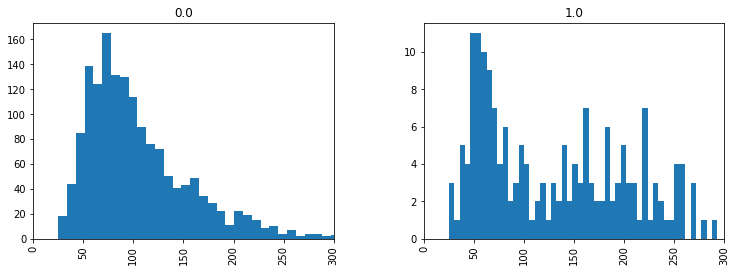

In [44]:
#length column
ax_list = df_clean.hist(column='length', by='target', bins=50,figsize=(12,4))
ax_list[0].set_xlim((0,300))
ax_list[1].set_xlim((0,300))

(0, 300)

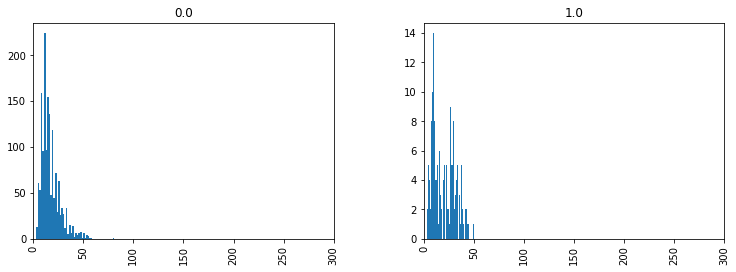

In [45]:
ax_list = df_clean.hist(column='words', by='target', bins=50,figsize=(12,4))
ax_list[0].set_xlim((0,300))
ax_list[1].set_xlim((0,300))

# Class for choosing extra features

In [46]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    

class TextSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def transform(self, X):
        return X[self.key]
    
    
class NumberSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[[self.key]]
    
    

In [47]:
df_clean.columns

Index(['target', 'text', 'length', 'words', 'hasTitle', 'hasContent',
       'hasLang', 'hasCountry1', 'hasCountry2', 'hasCountry3', 'hasCountry4',
       'num_countries'],
      dtype='object')

# Define a pipeline

In [48]:

text = Pipeline([
                ('selector', TextSelector("text")),
                ('tfidf', TfidfVectorizer())
            ])

length =  Pipeline([
                ('selector', NumberSelector("length")),
                ('standard', StandardScaler())
            ])

words =  Pipeline([
                ('selector', NumberSelector(key='words')),
                ('standard', StandardScaler())
            ])

        
hasTitle =  Pipeline([
                ('selector', NumberSelector(key='hasTitle')),
                ('standard', StandardScaler())
            ])

hasContent =  Pipeline([
                ('selector', NumberSelector(key='hasContent')),
                ('standard', StandardScaler()),
            ])
hasLang =  Pipeline([
                ('selector', NumberSelector(key='hasLang')),
                ('standard', StandardScaler()),
            ])
hasCountry1 =  Pipeline([
                ('selector', NumberSelector(key='hasCountry1')),
                ('standard', StandardScaler()),
            ])

hasCountry2 =  Pipeline([
                ('selector', NumberSelector(key='hasCountry2')),
                ('standard', StandardScaler()),
            ])
hasCountry3 =  Pipeline([
                ('selector', NumberSelector(key='hasCountry3')),
                ('standard', StandardScaler()),
            ])
hasCountry4 =  Pipeline([
                ('selector', NumberSelector(key='hasCountry4')),
                ('standard', StandardScaler()),
            ])
num_countries =  Pipeline([
                ('selector', NumberSelector(key='num_countries')),
                ('standard', StandardScaler()),
            ])

   
feats = FeatureUnion([('text', text), 
                      ('length', length),
                      ('words', words),
                      ('hasTitle', hasTitle),
                      #('avg_word_length', avg_word_length),
                      ('hasContent', hasContent),
                     ('hasLang', hasLang),
                     ('hasCountry1', hasCountry1),
                     #('n_adjs',n_adjs),
                      ('hasCountry2',hasCountry2),
                      ('hasCountry3',hasCountry3),
                      ('hasCountry4',hasCountry4),
                      ('num_countries',num_countries),
                     ])

feature_processing = Pipeline([('feats', feats)])

In [49]:
#df_clean = df_clean.reset_index(drop = True)
#df_clean

# Split train and test of clean data and fitting the model and predicting

In [50]:
# Split in train and validation
train_cl_data, val_cl_data = train_test_split(df_clean, test_size=0.2, random_state=42)



In [51]:
train_cl_data.isnull().sum()

target           0
text             0
length           0
words            0
hasTitle         0
hasContent       0
hasLang          0
hasCountry1      0
hasCountry2      0
hasCountry3      0
hasCountry4      0
num_countries    0
dtype: int64

In [52]:
train_cl_data = train_cl_data.dropna()
train_cl_data.isnull().sum()

target           0
text             0
length           0
words            0
hasTitle         0
hasContent       0
hasLang          0
hasCountry1      0
hasCountry2      0
hasCountry3      0
hasCountry4      0
num_countries    0
dtype: int64

In [53]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', EasyEnsembleClassifier(n_estimators=10,random_state = 42)),
    #('classifier', LinearRegression()),
])

pipeline.fit(train_cl_data, train_cl_data.target)

preds_val = pipeline.predict(val_cl_data)
np.mean(preds_val == val_cl_data.target)

0.6221590909090909

# Check classification results

In [54]:
# check the results
##print(classification_report(y_dev, y_dev_pred))
print(classification_report(val_cl_data['target'].values,preds_val))

              precision    recall  f1-score   support

         0.0       0.94      0.62      0.75       315
         1.0       0.17      0.65      0.27        37

    accuracy                           0.62       352
   macro avg       0.55      0.63      0.51       352
weighted avg       0.86      0.62      0.70       352



In [55]:
val_cl_data

,target,text,length,words,hasTitle,hasContent,hasLang,hasCountry1,hasCountry2,hasCountry3,hasCountry4,num_countries
1125,0.0,lysol disinfect coronavirus show virus new,72,11,0,0,0,1,1,1,1,4
1030,0.0,book name ahbarüz zaman predict coronavirus ep...,72,9,0,1,0,1,1,1,1,4
1683,1.0,vibrat includ come emot kill new coronavirus,80,11,0,0,0,1,1,1,1,4
1541,0.0,video show social distanc follow delhi,67,11,0,0,0,1,1,1,1,4
344,0.0,reach lung coronavirus remain throat day time ...,258,50,0,0,0,1,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.0,boil weed ginger covid19 victim virus vanish,70,12,0,0,0,1,1,1,1,4
1050,0.0,media group globo publish photo dead lampedusa...,113,20,0,0,0,1,1,1,1,4
1544,0.0,african resist covid19,41,6,0,0,0,1,1,1,1,4
1654,1.0,neem leaf malaria effici covid19,70,10,0,0,0,1,1,1,1,4


In [56]:
#test prediction
preds_test = pipeline.predict(df_clean_test)

In [57]:
df_clean_test['predicted'] = preds_test
df_clean_test

,text,length,words,hasTitle,hasContent,hasLang,hasCountry1,hasCountry2,hasCountry3,hasCountry4,num_countries,predicted
0,american research charl lieber arrest sell nov...,98,14,0,0,0,1,1,1,1,4,0.0
1,trump blame obama bad covid19 test wasnt time ...,242,34,0,0,0,1,1,1,1,4,1.0
2,hundr sampoerna cigarett factori worker covid19,63,8,0,0,0,1,1,1,1,4,0.0
3,dr megha vya pune die covid19,43,8,0,0,0,1,1,1,1,4,1.0
4,jacob rothschild own patent coronavirus,47,7,1,1,0,1,1,1,1,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2087,presid emmanuel macron cheer crowd fake suppor...,102,17,0,0,0,1,1,1,1,4,0.0
2088,helicopt go spray air disinfect overnight orde...,111,18,1,1,0,1,1,1,1,4,1.0
2089,coronavirus creat lab order destroy chines eco...,106,18,0,0,0,1,1,1,1,4,0.0
2090,video man dress white recommend take ivermecti...,151,24,0,0,0,1,1,1,1,4,0.0


In [58]:
df_clean_test['predicted']=df_clean_test['predicted'].replace({0:'false',1:'true'})
df_clean_test

,text,length,words,hasTitle,hasContent,hasLang,hasCountry1,hasCountry2,hasCountry3,hasCountry4,num_countries,predicted
0,american research charl lieber arrest sell nov...,98,14,0,0,0,1,1,1,1,4,false
1,trump blame obama bad covid19 test wasnt time ...,242,34,0,0,0,1,1,1,1,4,true
2,hundr sampoerna cigarett factori worker covid19,63,8,0,0,0,1,1,1,1,4,false
3,dr megha vya pune die covid19,43,8,0,0,0,1,1,1,1,4,true
4,jacob rothschild own patent coronavirus,47,7,1,1,0,1,1,1,1,4,true
...,...,...,...,...,...,...,...,...,...,...,...,...
2087,presid emmanuel macron cheer crowd fake suppor...,102,17,0,0,0,1,1,1,1,4,false
2088,helicopt go spray air disinfect overnight orde...,111,18,1,1,0,1,1,1,1,4,true
2089,coronavirus creat lab order destroy chines eco...,106,18,0,0,0,1,1,1,1,4,false
2090,video man dress white recommend take ivermecti...,151,24,0,0,0,1,1,1,1,4,false


In [59]:
#submission file
def create_submit(df):
    df_out=pd.DataFrame()
    df_out['class'] = df['predicted']
    return df_out
submission = create_submit(df_clean_test)
submission.to_csv("submission3.csv",index=False)

# How to reduce the features and choose the more important one
1- Feature Selection from chi-squared
2-Feature selection with SVD and PCA

# # The following will plot the  most dependent features from the chi-squared values.

In [60]:
#nltk.download("stopwords") 
#stopword_list =list(nltk.corpus.stopwords.words("english"))

In [61]:
#preprocess to run the following cell about chi_values
#df is already clean data
#Encode the lables y_train and y_dev
#vec = TfidfVectorizer(ngram_range=(1,2))
#X_train_vec = vec.fit_transform(train_cl_data.text)
#X_test_vec = vec.transform(test_cl_data.text)


In [62]:
#chi_values, p_values = chi2(X_train_vec, train_cl_data.target.values)
#print(chi_values, p_values)

In [63]:
#feature_names = vec.get_feature_names()

#cla()   # Clear axis
#close() # Close a figure window

#figure(figsize=(12,10))
#zipped_chi_squared = zip(feature_names, chi_values)
#sorted_chi_values = sorted(zipped_chi_squared, key=lambda x:x[1]) 
#top_chi_values = list(zip(*sorted_chi_values[-30:]))

#x = range(len(top_chi_values[1]))
#labels = top_chi_values[0]
#barh(x, list(top_chi_values)[1], align='center', alpha=.2, color='g')
#yticks(x, labels)
#xlabel('$\chi^2$')
#show()

# Ch2 choose best features

In [64]:
#ch2 = SelectKBest(chi2, k=10)
#ch2.fit(X_train_vec, train_cl_data.target)

#most_important_features = [feature_names[i] for i in ch2.get_support(indices=True)]
#for f in most_important_features:
 #   print(f)

# Prediction

In [65]:
#X_train_chi = ch2.transform(X_train_vec)
#X_test_chi = ch2.transform(X_test_vec)

#clf = MultinomialNB()
#%timeit clf.fit(X_train_chi, train_cl_data.target)

#y_pred = clf.predict(X_test_chi)